# Testing the accuracy of perturbative calculations
The simulator makes use of first-order perturbative calculations. The accuracy of these calculations is estimated through a comparison with exact calculations for small systems, for which an exact calculation is computationally feasible.

In [2]:
%load_ext autoreload
%autoreload 2

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matrixensembles import BosonChainSampler, MatrixStats, BosonOHSampler
from studies import ManyBodyLevels
import itertools
from utils import bosonmatplot, errorhist, paramstring
from operators import BosonSystemSpec

## Small system
This is a simulation of a small system. The eigenvalues and spacings can be inspected manually.

If $t=0$, the eigenstates are the canonical basis vectors and the perturbative calculation is exact. Indeed, the numerical calculation reports exactly the same values as the perturbative one.

For $t = 1$, the perturbative calculation seems to lose accuracy at around $K \approx 0.01$

In [47]:
### Exact
n, e = 4, 2
K = 0.01
t = 1
sampler = BosonChainSampler(n, 0., t, K=0, e=e)
sample = sampler.sample()
print(f"E with K=0: ", " ".join([f"{v:.4g}" for v in np.linalg.eigvalsh(sample)]))

sampler = BosonChainSampler(n, 0., t, K=K, e=e)
systemspec = BosonSystemSpec(n, e)
sample = sampler.sample()
bosonmatplot(systemspec, sample)
print()

### Perturbative
sampler = BosonChainSampler(n, 0., t, e=1)
study = ManyBodyLevels(e, K)
matrixstats = MatrixStats(sampler)
matrixstats.collect(n_realizations=1, eigenvectors=True)
manybody = study(matrixstats)
print("perturbative E: ", " ".join([f"{v:.4g}" for v in manybody.eigenvalues().flatten()]))
print("perturbative S: ", " ".join([f"{v:.4g}" for v in manybody.spacings().flatten()]))

E with K=0:  16 18 18 20 20 20 20 22 22 24
E:  16 18.01 18.01 20 20 20.01 20.02 22.01 22.01 24.01
S:  2.005 3.553e-15 1.99 3.553e-15 0.01 0.01 1.99 1.066e-14 1.995 

20.02 1.414 0 1.414 0 0 0 0 0 0  ;  2 0 0 0
1.414 20 1 0 1.414 0 1 0 0 0  ;  1 1 0 0
0 1 20 1 0 1 0 0 1 0  ;  1 0 1 0
1.414 0 1 20 0 0 1 0 0 1.414  ;  1 0 0 1
0 1.414 0 0 20.02 1.414 0 0 0 0  ;  0 2 0 0
0 0 1 0 1.414 20 1 1.414 0 0  ;  0 1 1 0
0 1 0 1 0 1 20 0 1 0  ;  0 1 0 1
0 0 0 0 0 1.414 0 20.02 1.414 0  ;  0 0 2 0
0 0 1 0 0 0 1 1.414 20 1.414  ;  0 0 1 1
0 0 0 1.414 0 0 0 0 1.414 20.02  ;  0 0 0 2



100%|██████████| 10/10 [00:00<00:00, 15691.37it/s]

perturbative E:  16 18.01 18.01 20 20.01 20.01 20.01 22.01 22.01 24
perturbative S:  2.005 0 1.99 0.01 0 3.553e-15 2 3.553e-15 1.995


## Manual verification

Let's consider the following system. Eigenvalues are calculated with the exact method, with the perturbative method, and with the perturbative formula derived by hand for 2 bosons.

The two perturbative calculations are in perfect agreement. The perturbative calculation is close to the exact one, but not enough to get correct spacings, as shown afterwards.

In [39]:
n, e = 4, 2
K = 0.1
t = 1
W = 0.5
# exact
rng = np.random.default_rng(seed=42)
sampler = BosonChainSampler(n, W, t, K=K, e=e, rng=rng)
sample = sampler.sample()
exact_eigenvalues = np.linalg.eigvalsh(sample)

# perturbative
rng = np.random.default_rng(seed=42)
sampler = BosonChainSampler(n, W, t, e=1, rng=rng)
study = ManyBodyLevels(e, K)
matrixstats = MatrixStats(sampler)
matrixstats.collect(n_realizations=1, eigenvectors=True)
manybody = study(matrixstats)
eigenvalues = np.linalg.eigvalsh(sampler.sample())
print("exact eigenvalues:                 ", " ".join([f"{v:.3f}" for v in exact_eigenvalues]))
print("perturbative eigenvalues:          ", " ".join([f"{v:.3f}" for v in manybody.eigenvalues().flatten()]))

# calculate perturbation by hand
def pert_2(v1, v2):
	""" First order perturbation for two particles in states v1 and v2. """
	dE = 4*K*np.sum(np.abs(v1*v2)**2) / (1 + np.abs(np.sum(np.conj(v1)*v2))**2)
	return dE

evc = matrixstats.eigenvectors()
eva = matrixstats.eigenvalues()
pert_E = []
for i, j in itertools.combinations_with_replacement(range(n), 2):
	v1, v2 = evc[0, :, i], evc[0, :, j]
	pert_E.append(eva[0, i] + eva[0, j] + pert_2(v1, v2))

pert_E = np.sort(pert_E)
print("perturbative eigenvalues (by hand):", " ".join([f"{v:.3f}" for v in pert_E]))

100%|██████████| 1/1 [00:00<00:00, 479.62it/s]


100%|██████████| 10/10 [00:00<00:00, 7704.45it/s]

exact eigenvalues:                  16.142 18.139 18.392 20.053 20.264 20.318 20.642 22.272 22.552 24.417
perturbative eigenvalues:           16.144 18.141 18.395 20.066 20.270 20.311 20.629 22.269 22.549 24.416
perturbative eigenvalues (by hand): 16.144 18.141 18.395 20.066 20.270 20.311 20.629 22.269 22.549 24.416


### Inspecting the states
Eigenvalues and vectors can be inspected to have a further confirmation that everything is as expected. Consider the eigenstate $\left|1100\right>$ in diagonal basis, second quantization. The single particle eigenvectors $\left|1000\right>$ and $\left|0100\right>$ in the single-particle canonical basis are:

In [51]:
evc = matrixstats.eigenvectors()
eva = matrixstats.eigenvalues()
print(f"E={eva[0, 0]:.2f} eigenvector: ", " ".join([f"{v:.3f}" for v in evc[0, :, 0]]))
print(f"E={eva[0, 1]:.2f} eigenvector: ", " ".join([f"{v:.3f}" for v in evc[0, :, 1]]))

# check that they are actually eigenvectors
mat = sampler.sample().get() # the randomness is turned off,
# so the sample is the same as the previous one
print("They really are eigenvectors")
print("Eigenvector 1: ", " ".join([f"{v:.3f}" for v in mat @ evc[0, :, 0] / eva[0, 0]]))
print("Eigenvector 2: ", " ".join([f"{v:.3f}" for v in mat @ evc[0, :, 1] / eva[0, 1]]))

E=8.00 eigenvector:  0.500 -0.500 0.500 -0.500
E=10.00 eigenvector:  -0.707 -0.000 0.707 0.000
They really are eigenvectors
Eigenvector 1:  0.500 -0.500 0.500 -0.500
Eigenvector 2:  -0.707 -0.000 0.707 0.000


## Comparison of 2-particle correlation statistic

The average correlation between adjacent spacings ($r$ scalar) is calculated with the exact method as well as the perturbative one. The perturbative method is not able to reach a high $r$, it seems like it always sees Poisson-distributed energies.

In [ ]:
### Exact
n, e = 10, 5
K = 0.1
sampler = BosonChainSampler(n, 2, 1, K=K, e=e, w0=100)
matrixstats = MatrixStats(sampler)
matrixstats.collect(n_realizations=20, eigenvectors=False)
print(f"r = {np.mean(matrixstats.d2correlations()):.2f}\n")

### Perturbative
sampler = BosonChainSampler(n, 2, 1, e=1, w0=100)
study = ManyBodyLevels(e, K)
matrixstats = MatrixStats(sampler)
matrixstats.collect(n_realizations=20, eigenvectors=True)
manybody = study(matrixstats)
print(f"r = {np.mean(manybody.d2correlations()):.2f}\n")

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:09<00:00,  2.10it/s]


r = 0.42



100%|██████████| 2002/2002 [00:00<00:00, 5537.43it/s]

r = 0.39



### Dependency between errors on spacings and perturbation strength
A small system is considered and the spacings distribution is calculated with the exact method as well as the perturbative one. The two methods of calculation do not agree.

In [53]:
K = 0.1
### Exact
n, e = 10, 5
sampler = BosonChainSampler(n, 2, 1, K=K, e=e, w0=100)
matrixstats = MatrixStats(sampler)
matrixstats.collect(n_realizations=1000, eigenvectors=False)

### Perturbative
sampler = BosonChainSampler(n, 2, 1, e=1, w0=100)
study = ManyBodyLevels(e, K)
sstats = MatrixStats(sampler)
sstats.collect(n_realizations=1000, eigenvectors=True)
manybody = study(sstats)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 2002/2002 [00:13<00:00, 146.05it/s]


Area error: 11.9%


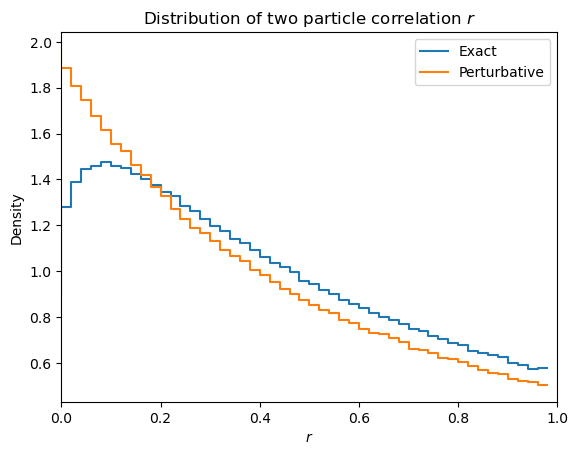

In [57]:
rg = (matrixstats.d2correlations().min(), matrixstats.d2correlations().max())
exact_hist, exact_edges = np.histogram(matrixstats.d2correlations(), bins=50, range=rg, density=True)
pert_hist, pert_edges = np.histogram(manybody.d2correlations(), bins=50, range=rg, density=True)
plt.step(exact_edges[:-1], exact_hist, label="Exact", where="pre")
plt.step(pert_edges[:-1], pert_hist, label="Perturbative", where="pre")
plt.xlim(0, 1.)
plt.legend()
plt.xlabel(r"$r$")
plt.ylabel(r"Density")
plt.title("Distribution of two particle correlation $r$")
error_percentage = np.sum(np.abs(exact_hist - pert_hist) * (exact_edges[1] - exact_edges[0]))
print(f"Area error: {error_percentage:.1%}")